In [17]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
# !unzip "/content/gdrive/MyDrive/IISc_Internship/FER/FER.zip" -d "/content/gdrive/MyDrive/IISc_Internship/FER/Extracted" 

In [1]:
import tensorflow as tf
import keras 
import os
import numpy as np
import datetime
np.random.seed(1)
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.utils.vis_utils import plot_model

dim_colour="darkgrey"
main_accent_colour = "#b366ff"

In [3]:
# IMG_HEIGHT=64
# IMG_WIDTH=64
# IMG_CHANNELS=1

In [2]:
train_dir ='ThreeChannels/train/'
test_dir = 'ThreeChannels/test/'

row = 64
col = 64
classes = 7

In [3]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
angry folder contains		 3995 image
disgust folder contains		 436 image
fear folder contains		 4097 image
happy folder contains		 7214 image
neutral folder contains		 4965 image
sad folder contains		 4830 image
surprise folder contains		 3171 image

Test Set :
angry folder contains		 958 images
disgust folder contains		 111 images
fear folder contains		 1024 images
happy folder contains		 1774 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
surprise folder contains		 831 images


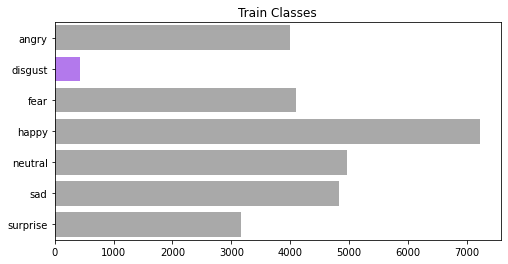

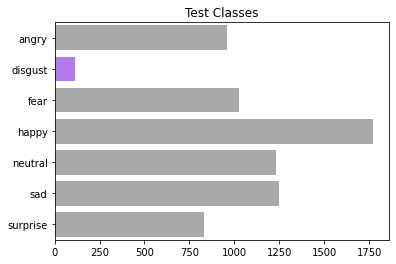

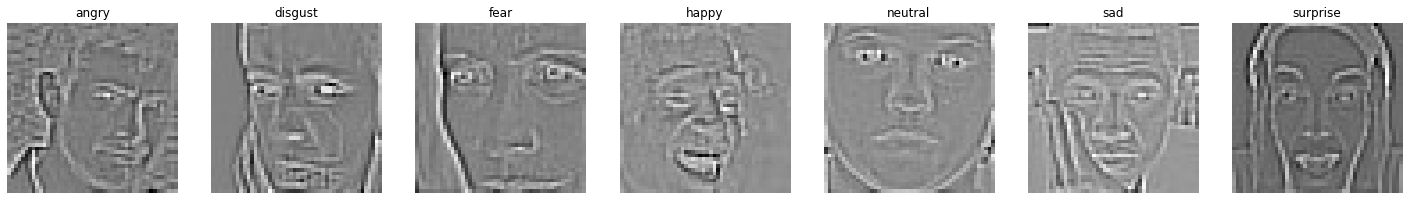

In [4]:
vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_dir),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):
    
    img = load_img((train_dir + folder +'/'+ os.listdir(train_dir + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(64,64),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(64,64),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [7]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2),padding='same',strides=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same',strides=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same',strides=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same',strides=2))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(7,activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [39]:
# inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
# c11=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(inputs)
# n11=tf.keras.layers.BatchNormalization(axis=-1)(c11)
# c12=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(n11)
# n12=tf.keras.layers.BatchNormalization(axis=-1)(c12)
# p1=tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',strides=2)(n12)
# d1=tf.keras.layers.Dropout(0.25)(p1)

# c21=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(d1)
# n21=tf.keras.layers.BatchNormalization(axis=-1)(c21)
# c22=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(n21)
# n22=tf.keras.layers.BatchNormalization(axis=-1)(c22)
# p2=tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',strides=2)(n22)
# d2=tf.keras.layers.Dropout(0.25)(p2)

# c31=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(d2)
# n31=tf.keras.layers.BatchNormalization(axis=-1)(c31)
# c32=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(n31)
# n32=tf.keras.layers.BatchNormalization(axis=-1)(c32)
# c33=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(n32)
# n33=tf.keras.layers.BatchNormalization(axis=-1)(c33)
# p3=tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',strides=2)(n33)
# d3=tf.keras.layers.Dropout(0.25)(p3)


# c41=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(d3)
# n41=tf.keras.layers.BatchNormalization(axis=-1)(c41)
# c42=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(n41)
# n42=tf.keras.layers.BatchNormalization(axis=-1)(c42)
# c43=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(n42)
# n43=tf.keras.layers.BatchNormalization(axis=-1)(c43)
# p4=tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',strides=2)(n43)
# d4=tf.keras.layers.Dropout(0.25)(p4)

# flat=tf.keras.layers.Flatten()(d4)

# fc1=tf.keras.layers.Dense(1024)(flat)
# ac1= tf.keras.layers.Activation('relu')(fc1)
# dfc1=tf.keras.layers.Dropout(rate=0.50)(ac1)

# fc2=tf.keras.layers.Dense(1024)(dfc1)
# ac2= tf.keras.layers.Activation('relu')(fc2)
# dfc2=tf.keras.layers.Dropout(rate=0.50)(ac2)

# # Change the below line for 8 output classes as expected
# fc3=tf.keras.layers.Dense(7)(dfc2)
# outputs=tf.keras.layers.Activation('softmax')(fc3)

# model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
# model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

# print(model.summary())

In [8]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

c:\Users\Sanchit Kanda\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# plot_model(fernet, show_layer_names=True)

In [10]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [11]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=150,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 23/448 [>.............................] - ETA: 30:12 - loss: 2.5117 - accuracy: 0.1753

KeyboardInterrupt: 

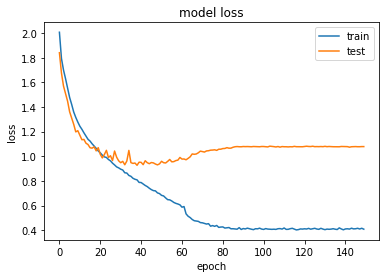

In [11]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

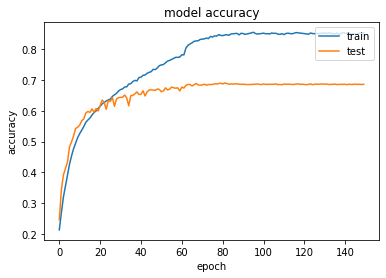

In [12]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [13]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 2s 20ms/step - loss: 1.0778 - accuracy: 0.6854
final train accuracy = 89.93 , validation accuracy = 68.54


449/449 [==============================] - 21s 47ms/step
Confusion Matrix
[[ 558   77  563  969  736  656  436]
 [  63    6   67   98   92   59   51]
 [ 539   66  534 1060  758  679  461]
 [ 961  110  979 1863 1282 1191  829]
 [ 687   86  661 1273  904  782  572]
 [ 642   70  639 1224  869  822  564]
 [ 416   53  450  830  551  534  337]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.13      0.13      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.10      0.11      0.10      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



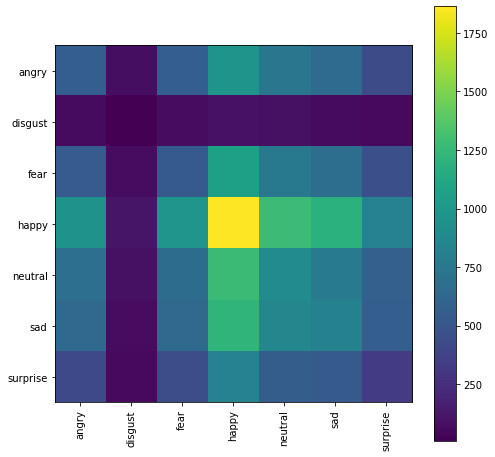

In [14]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)